# Load all Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.applications.resnet50 import ResNet50
from keras.regularizers import l2

Using TensorFlow backend.


## Paths and Image Generators

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [3]:
test_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_generator = train_datagen.flow_from_directory(
        directory="/floyd/input/birds/train",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=42)

Found 24497 images belonging to 180 classes.


In [5]:
valid_generator = validation_datagen.flow_from_directory(
        directory="/floyd/input/birds/valid",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=42)

Found 900 images belonging to 180 classes.


In [6]:
test_generator = test_datagen.flow_from_directory(
        directory="/floyd/input/birds/test",
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 900 images belonging to 180 classes.


# Model Definition

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# and a logistic layer --  we have 180 classes
predictions = Dense(180,kernel_regularizer=l2(0.01), activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

# Training

In [9]:
filepath = "saved-model-{epoch:02d}-{val_loss:.2f}.hdf5"
saver=ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [saver]

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=int(24497/32),
                    validation_data=valid_generator,
                    validation_steps=int(900/32),
                    callbacks=callbacks_list,
                    epochs=20)

Epoch 1/20
765/765 [==============================] - 303s 396ms/step - loss: 3.2882 - accuracy: 0.3584 - val_loss: 6.5008 - val_accuracy: 0.0257

Epoch 00001: saving model to saved-model-01-6.50.hdf5
Epoch 2/20
765/765 [==============================] - 278s 363ms/step - loss: 1.4661 - accuracy: 0.6888 - val_loss: 2.0954 - val_accuracy: 0.5415

Epoch 00002: saving model to saved-model-02-2.10.hdf5
Epoch 3/20
765/765 [==============================] - 276s 361ms/step - loss: 1.0770 - accuracy: 0.7757 - val_loss: 1.0251 - val_accuracy: 0.7396

Epoch 00003: saving model to saved-model-03-1.03.hdf5
Epoch 4/20
765/765 [==============================] - 283s 370ms/step - loss: 0.8973 - accuracy: 0.8173 - val_loss: 0.5086 - val_accuracy: 0.8618

Epoch 00004: saving model to saved-model-04-0.51.hdf5
Epoch 5/20
765/765 [==============================] - 277s 362ms/step - loss: 0.7603 - accuracy: 0.8465 - val_loss: 1.1026 - val_accuracy: 0.8088

Epoch 00005: saving model to saved-model-05-1.10.

Training and Validation Learning Curve



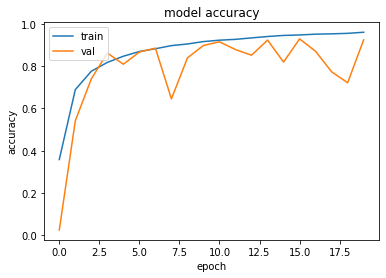

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Training and Validation Loss Curve



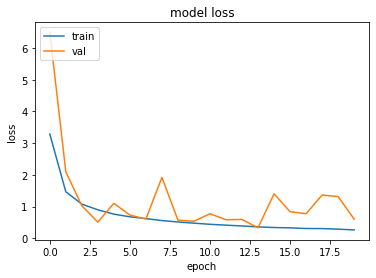

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load Best Model

In [8]:
model = load_model('saved-model-14-0.33.hdf5') #it converged here

In [11]:
print('Testing loss:', score[0])
print('Testing accuracy:', score[1])

Testing loss: 0.14913460612297058
Testing accuracy: 0.9355555772781372


# Evaluate Test Results and Classification Report

In [ ]:
labels = test_generator.class_indices
real = []
pred = []

In [ ]:
results = model.predict_generator(generator=test_generator,verbose=1,workers=1,max_queue_size=1)
y_pred = np.argmax(results,axis=-1)

In [13]:
true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print(confusion_matrix(test_generator.classes, y_pred))
results = model.evaluate_generator(generator=test_generator,workers=1,pickle_safe=False,max_queue_size=1)
print('Testing loss:' + str(results[0]))
print('Testing Accuracy:' + str(results[1]*100))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(generator=<keras.pre..., workers=1, max_queue_size=1, use_multiprocessing=False)`
  


Testing loss:0.14913460612297058
Testing Accuracy:93.55555772781372
                           precision    recall  f1-score   support

                ALBATROSS       0.56      1.00      0.71         5
     ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
          AMERICAN AVOCET       0.83      1.00      0.91         5
         AMERICAN BITTERN       1.00      1.00      1.00         5
            AMERICAN COOT       1.00      1.00      1.00         5
       AMERICAN GOLDFINCH       1.00      1.00      1.00         5
         AMERICAN KESTREL       1.00      1.00      1.00         5
           AMERICAN PIPIT       1.00      1.00      1.00         5
        AMERICAN REDSTART       0.83      1.00      0.91         5
                  ANHINGA       1.00      1.00      1.00         5
        ANNAS HUMMINGBIRD       1.00      1.00      1.00         5
                  ANTBIRD       1.00      0.80      0.89         5
          ARARIPE MANAKIN       1.00      1.00      1.00    